# Mercari Price Suggestion Challenge

For the Kaggle competition "Mercari Price Suggestion Challenge", we were tasked to write code to predict prices. This is my suggestion. There are three steps: 

1. EDA
2. Data Engineering
3. Machine Learning

The challenge was completed in mid-February of 2018 and I scored among the top 50% of over 2300 sbumission. This was my first ever Kaggle competition. 


## Exploratory Data Analysis

The data is organized like so:

- train_id or test_id - the id of the listing
- name - the title of the listing
- item_condition_id - the condition of the items provided by the seller
- category_name - category of the listing
- brand_name
- price - the price that the item was sold for, also the **target variable**
- shipping - 1 if shipping fee is paid by seller and 0 by buyer
- item_description - the full description of the item

The first natural step is to look at the distribituion of prices.


In [1]:
from time import time
import pandas as pd
import numpy as np
import string
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import svm
from sklearn import preprocessing
from sklearn.ensemble import RandomForestRegressor
print "Importing"

t0 = time()


test=pd.read_csv("C:/Users/Malte/OneDrive/Coding/My repositories/Mercari/test.tsv",sep="\t")

train=pd.read_csv("C:/Users/Malte/OneDrive/Coding/My repositories/Mercari/train.tsv",sep="\t")

train=train[:1000]
test=test[:1000]


Importing


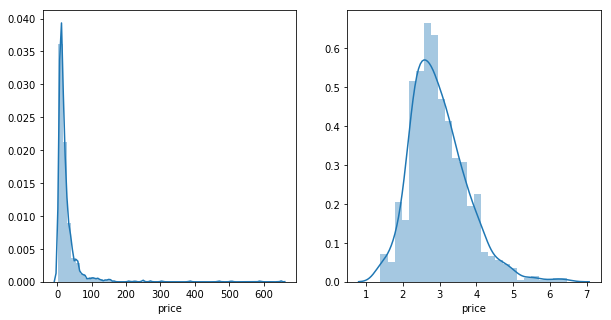

In [2]:
fig,(ax) = plt.subplots(1,2,figsize=(10,5))
sns.distplot(train["price"],ax=ax[0])
sns.distplot(np.log1p(train["price"]),ax=ax[1])